### **ICU Patient Outcomes – Exploratory Data Analysis (EDA)**

---

**Overview**

This notebook is the initial starting point for a comprehensive data science project aimed at improving hospital care. The analysis conducted here leverages the **MIMIC-IV Clinical Database Demo**, which contains detailed medical records for 100 ICU patients.  

The primary goal of the project is to analyze ICU patient data in order to identify patterns and factors associated with patient outcomes and care delivery. Within this notebook, the focus is on conducting **exploratory data analysis (EDA)** to assess the structure, quality, and key patterns of the dataset, laying the foundation for subsequent modeling and deeper clinical insights.

---

**Context**
- **Data source:** MIMIC-IV Clinical Database Demo (Beth Israel Deaconess Medical Center, curated by MIT LCP).  
- **Modules used:** `hosp` (hospital-wide events) and `icu` (ICU-specific stays and monitoring).  
- **Scope:** Clean, load, and profile core tables
- **Outputs:** Baseline summary statistics, distributions, and data quality checks.

---

**Purpose**
- Provide a structured foundation for downstream analysis.  
- Generate descriptive statistics and visualizations to understand ICU patient demographics, admissions, diagnoses, and outcomes.  
- Identify potential data issues (missingness, outliers, duplicates) that may affect later modeling.  

---

### **Step 0: Import Modules**

The initial code block imports all the Python modules needed for this notebook. These include libraries for data manipulation, numerical analysis, visualization, and basic system information to support reproducibility.

**Code breakdown:**
 
 - Import core libraries &rarr; `pandas`, `numpy`, `matplotlib`, `seaborn`
 - Import utility modules &rarr; `os`, `sys`, `platform`, `re`, `glob`, `Path`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, platform, re, glob
from pathlib import Path

### **Step 1: Load data**

> **Step 1.1:**
> - The first code block loads the `demo_subject_id.csv` file, which contains the 100 patients included in the demo dataset. This file is used to
>   filter the other tables so that only rows corresponding to these patients are analyzed
> - **Code breakdown:**
>   - Load the `demo_subject_id.csv` file into a DataFrame
>   - Confirm the number of unique patient IDs matches expectations (100)

> **Step 1.2:**
> - The second code block loads all CSV files from the **hosp** module. This module contains hospital-wide data such as admissions, diagnoses,
>   procedures, labs, and pharmacy events.
> - **Code breakdown:**
>   - Read each CSV file in the `data/hosp` directory into a separate DataFrame
>   - Store DataFrames in variables named after each respective file for clarity
>   - Print basic shapes to confirm successful loading

> **Step 1.3:**
> - The third code block loads all CSV files from the **icu** module. This module contains ICU-specific data such as stays, chart events, and 
>   caregiver information
> - **Code breakdown:**
>   - Read each CSV file in the `data/icu` directory into a separate DataFrame
>   - Store DataFrames in variables named after the file for clarity
>   - Print basic shapes to confirm successful loading

In [2]:
# Load demo subject IDs (100 patients in the demo dataset)
demo_ids = pd.read_csv("../data/demo_subject_id.csv")
print("Demo subject IDs shape:", demo_ids.shape)
print("Unique subject_id count:", demo_ids["subject_id"].nunique())
demo_ids.head()

Demo subject IDs shape: (100, 1)
Unique subject_id count: 100


,subject_id
0,10000032
1,10001217
2,10001725
3,10002428
4,10002495


In [3]:
def load_all_csv_files(folder: Path):
    data = {}
    for p in folder.glob("*.csv"):
        if p.is_file():
            # Case 1: plain CSV file
            name = p.stem
            df = pd.read_csv(p, low_memory=False)
            data[name] = df
            print(f"Loaded {name}: {df.shape}")
        elif p.is_dir():
            # Case 2/3: directory named *.csv
            same_named = p / p.name  # e.g., admissions.csv/admissions.csv
            if same_named.exists() and same_named.is_file():
                name = p.stem
                df = pd.read_csv(same_named, low_memory=False)
                data[name] = df
                print(f"Loaded (dir->file) {name}: {df.shape}")
            else:
                # Fallback: pick the first CSV inside the folder
                candidates = sorted(p.glob("*.csv"))
                if candidates:
                    name = p.stem
                    df = pd.read_csv(candidates[0], low_memory=False)
                    data[name] = df
                    print(f"Loaded (dir->first) {name}: {df.shape}")
                else:
                    print(f"⚠️ No CSV file found inside directory: {p}")
    return data

In [4]:
hosp_dir = Path("../data/hosp")
icu_dir  = Path("../data/icu")

In [5]:
hosp_data = load_all_csv_files(hosp_dir)

Loaded (dir->file) admissions: (275, 16)
Loaded (dir->file) diagnoses_icd: (4507, 5)
Loaded (dir->file) drgcodes: (454, 7)
Loaded (dir->file) d_hcpcs: (89200, 4)
Loaded (dir->file) d_icd_diagnoses: (109775, 3)
Loaded (dir->file) d_icd_procedures: (85257, 3)
Loaded (dir->file) d_labitems: (1622, 4)
Loaded (dir->file) emar: (35835, 12)
Loaded (dir->file) hcpcsevent: (62, 6)
Loaded (dir->file) labevents: (107727, 16)
Loaded (dir->file) microbiologyevents: (2899, 25)
Loaded (dir->file) omr: (2964, 5)
Loaded (dir->file) patients: (100, 6)
Loaded (dir->file) pharmacy: (15306, 27)
Loaded (dir->file) poe: (45154, 12)
Loaded (dir->file) poe_detail: (3795, 5)
Loaded (dir->file) prescriptions: (18087, 21)
Loaded (dir->file) procedures_icd: (723, 6)
Loaded (dir->file) provider: (40509, 1)
Loaded (dir->file) services: (319, 5)
Loaded (dir->file) transfers: (1190, 7)


In [6]:
icu_data  = load_all_csv_files(icu_dir)

Loaded (dir->file) caregiver: (15469, 1)
Loaded (dir->file) chartevents: (668862, 11)
Loaded (dir->file) datetimeevents: (15280, 10)
Loaded (dir->file) icustays: (140, 8)
Loaded (dir->file) ingredientevents: (25728, 17)
Loaded (dir->file) inputevents: (20404, 26)
Loaded (dir->file) outputevents: (9362, 9)
Loaded (dir->file) procedureevents: (1468, 22)


In [7]:
print("\n=== HOSP MODULE TABLES ===")
for name, df in hosp_data.items():
    subj = df["subject_id"].nunique() if "subject_id" in df.columns else "-"
    print(f"{name:<25} shape={df.shape} | unique subject_id={subj}")


=== HOSP MODULE TABLES ===
admissions                shape=(275, 16) | unique subject_id=100
diagnoses_icd             shape=(4507, 5) | unique subject_id=101
drgcodes                  shape=(454, 7) | unique subject_id=100
d_hcpcs                   shape=(89200, 4) | unique subject_id=-
d_icd_diagnoses           shape=(109775, 3) | unique subject_id=-
d_icd_procedures          shape=(85257, 3) | unique subject_id=-
d_labitems                shape=(1622, 4) | unique subject_id=-
emar                      shape=(35835, 12) | unique subject_id=65
hcpcsevent                shape=(62, 6) | unique subject_id=-
labevents                 shape=(107727, 16) | unique subject_id=100
microbiologyevents        shape=(2899, 25) | unique subject_id=97
omr                       shape=(2964, 5) | unique subject_id=79
patients                  shape=(100, 6) | unique subject_id=100
pharmacy                  shape=(15306, 27) | unique subject_id=100
poe                       shape=(45154, 12) | unique 

In [8]:
print("\n=== ICU MODULE TABLES ===")
for name, df in icu_data.items():
    subj = df["subject_id"].nunique() if "subject_id" in df.columns else "-"
    print(f"{name:<25} shape={df.shape} | unique subject_id={subj}")


=== ICU MODULE TABLES ===
caregiver                 shape=(15469, 1) | unique subject_id=-
chartevents               shape=(668862, 11) | unique subject_id=100
datetimeevents            shape=(15280, 10) | unique subject_id=100
icustays                  shape=(140, 8) | unique subject_id=100
ingredientevents          shape=(25728, 17) | unique subject_id=99
inputevents               shape=(20404, 26) | unique subject_id=99
outputevents              shape=(9362, 9) | unique subject_id=100
procedureevents           shape=(1468, 22) | unique subject_id=100


In [9]:
# Extract list of demo subject IDs
demo_subjects = set(demo_ids["subject_id"])

def filter_to_demo(data_dict, demo_subjects):
    """Filter all tables in a module dictionary to only include demo subject IDs."""
    filtered = {}
    for name, df in data_dict.items():
        if "subject_id" in df.columns:
            before = df.shape[0]
            df = df[df["subject_id"].isin(demo_subjects)]
            after = df.shape[0]
            print(f"{name:<25} rows before={before:<6} after={after:<6}")
        else:
            print(f"{name:<25} (no subject_id column, left unchanged)")
        filtered[name] = df
    return filtered

# Apply filtering
hosp_data_demo = filter_to_demo(hosp_data, demo_subjects)
print()
icu_data_demo  = filter_to_demo(icu_data, demo_subjects)

admissions                rows before=275    after=275   
diagnoses_icd             rows before=4507   after=0     
drgcodes                  rows before=454    after=454   
d_hcpcs                   (no subject_id column, left unchanged)
d_icd_diagnoses           (no subject_id column, left unchanged)
d_icd_procedures          (no subject_id column, left unchanged)
d_labitems                (no subject_id column, left unchanged)
emar                      rows before=35835  after=35835 
hcpcsevent                (no subject_id column, left unchanged)
labevents                 rows before=107727 after=107727
microbiologyevents        rows before=2899   after=2899  
omr                       rows before=2964   after=2964  
patients                  rows before=100    after=100   
pharmacy                  rows before=15306  after=15306 
poe                       rows before=45154  after=45154 
poe_detail                rows before=3795   after=3795  
prescriptions             rows before

In [10]:
def build_table_overview(named_dsets: dict):
    """
    named_dsets: {"hosp": hosp_data, "icu": icu_data}
    Returns a DataFrame with one row per table.
    """
    rows = []
    for ns, dct in named_dsets.items():
        for name, df in dct.items():
            info = {
                "namespace": ns,
                "table": name,
                "rows": len(df),
                "cols": df.shape[1],
                "memory_mb": round(df.memory_usage(deep=True).sum() / 1e6, 2),
            }
            for key in ("subject_id", "hadm_id", "stay_id"):
                has_key = key in df.columns
                info[f"has_{key}"] = has_key
                if has_key:
                    info[f"nunique_{key}"] = df[key].nunique()
            rows.append(info)
    ov = pd.DataFrame(rows)
    # nice sort: bigger tables first, then namespace/table
    ov = ov.sort_values(["namespace", "rows"], ascending=[True, False], ignore_index=True)
    return ov

overview = build_table_overview({"hosp": hosp_data, "icu": icu_data})
overview

,namespace,table,rows,cols,memory_mb,has_subject_id,nunique_subject_id,has_hadm_id,nunique_hadm_id,has_stay_id,nunique_stay_id
0,hosp,d_icd_diagnoses,109775,3,19.80,False,NaN,False,NaN,False,NaN
1,hosp,labevents,107727,16,50.61,True,100.0,True,252.0,False,NaN
2,hosp,d_hcpcs,89200,4,15.30,False,NaN,False,NaN,False,NaN
3,hosp,d_icd_procedures,85257,3,15.80,False,NaN,False,NaN,False,NaN
4,hosp,poe,45154,12,22.35,True,100.0,True,272.0,False,NaN
5,hosp,provider,40509,1,2.23,False,NaN,False,NaN,False,NaN
6,hosp,emar,35835,12,18.50,True,65.0,True,181.0,False,NaN
7,hosp,prescriptions,18087,21,15.88,True,100.0,True,250.0,False,NaN
8,hosp,pharmacy,15306,27,15.30,True,100.0,True,250.0,False,NaN
9,hosp,diagnoses_icd,4507,5,1.21,True,101.0,True,276.0,False,NaN


### **Step 2: Exploratory Data Analysis**

**ICU Length of Stay (LOS) Distribution**

**Purpose:**
- Understanding ICU length of stay (LOS) is critical to operational efficiency. Establishing the baseline LOS distribution provides the reference point for evaluating whether future interventions reduce average ICU stay duration.

**Code breakdown:**
- **Copy ICU stays table**: Work on a copy of the `icustays` table to avoid modifying the original dataset.
- **Compute LOS in days**: Convert `intime` and `outtime` columns to datetime, take their difference, and transform from seconds into days.  
- **Create histogram with KDE**: Use seaborn’s `histplot` to display the distribution of LOS values and overlay a kernel density estimate (KDE) curve for smoother visualization.  
- **Add mean reference line**: Plot a vertical dashed red line at the mean LOS to indicate the baseline average.  
- **Add plot labels and legend**: Label axes, set a title, and display the mean LOS in the legend for interpretability.

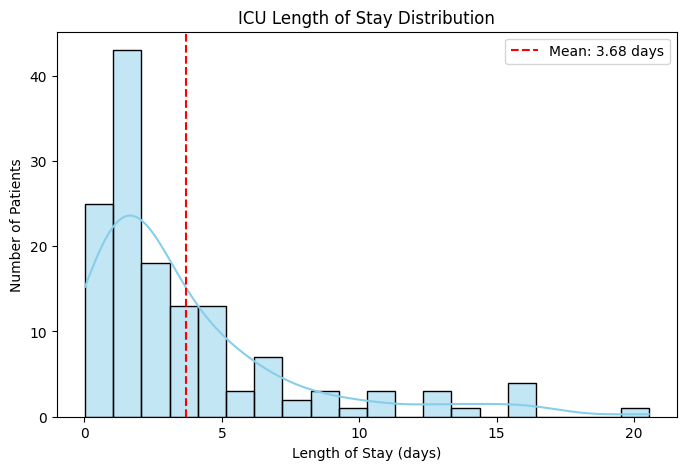

In [11]:
# Calculate ICU Length of Stay (LOS) in days
icustays = icu_data["icustays"].copy()
icustays["los_days"] = (
    pd.to_datetime(icustays["outtime"]) - pd.to_datetime(icustays["intime"])
).dt.total_seconds() / (3600*24)

# Plot LOS distribution with seaborn
plt.figure(figsize=(8,5))
sns.histplot(icustays["los_days"], bins=20, kde=True, color="skyblue")

# Add mean reference line
plt.axvline(icustays["los_days"].mean(), color="red", linestyle="--", 
            label=f"Mean: {icustays['los_days'].mean():.2f} days")

plt.title("ICU Length of Stay Distribution")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Number of Patients")
plt.legend()
plt.show()

**In-Hospital Mortality Rate**

**Purpose:**
- Mortality is a central quality outcome for ICU care. Quantifying the baseline in-hospital mortality rate allows RMC to track whether efficiency improvements also affect patient survival.

**Code breakdown:**
- **Copy admissions table**: Work on a copy of the `admissions` table to keep the original dataset unchanged.  
- **Flag mortality**: Create a binary column `mortality` where `1 = patient died` if `deathtime` is not null, otherwise `0`.  
- **Count mortality outcomes**: Use `value_counts()` to calculate how many admissions ended in survival vs. death.
- **Plot proportions with seaborn**: Create a bar plot showing the proportion of admissions that resulted in survival versus death. 
- **Customize labels**: Replace `0`/`1` ticks with `Survived` and `Died` for readability, add axis labels, and a descriptive title.

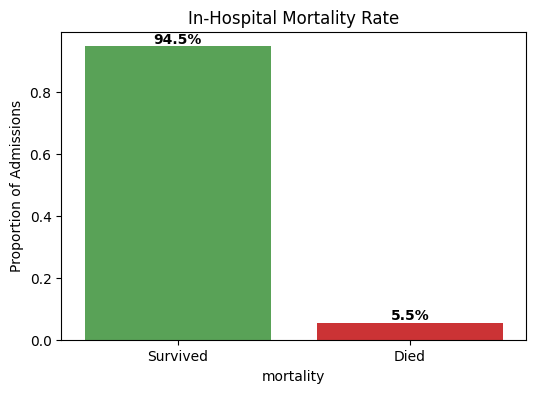

In [12]:
# Copy admissions table
admissions = hosp_data["admissions"].copy()

# Flag mortality (1 = patient died, 0 = survived)
admissions["mortality"] = admissions["deathtime"].notnull().astype(int)

# Compute percentages for annotation
counts = admissions["mortality"].value_counts()
props = counts / counts.sum() * 100

# Plot mortality proportions
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=admissions,
    x="mortality",
    y="mortality",
    estimator=lambda x: len(x) / len(admissions),
    hue="mortality",
    palette=["#4daf4a", "#e41a1c"],
    legend=False
)

# Customize plot
ax.set_xticks([0,1])
ax.set_xticklabels(["Survived","Died"])
ax.set_ylabel("Proportion of Admissions")
ax.set_title("In-Hospital Mortality Rate")

# Add percentage labels above bars
for p, pct in zip(ax.patches, props):
    ax.annotate(f"{pct:.1f}%", 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.show()

**30-Day Readmission Rate**

**Purpose:**
- Frequent readmissions drive costs and indicate gaps in care. Measuring the proportion of patients readmitted within 30 days provides a baseline for the project’s goal of reducing readmissions.

**Code breakdown:**
- **Sort admissions chronologically**: Order each patient’s admissions by `admittime` to establish the sequence of hospital visits.  
- **Find next admission**: Use `groupby("subject_id")` with `shift(-1)` to capture the date of each patient’s next admission.  
- **Flag 30-day readmissions**: Create a boolean column `readmit_within_30d` that is `True` if the next admission occurs within 30 days of discharge.  
- **Count readmission outcomes**: Use `value_counts()` to determine the share of admissions followed by a 30-day readmission versus not.  
- **Plot proportions with seaborn**: Build a bar plot comparing the two categories, label the bars as `No Readmit ≤30d` and `Readmit ≤30d`, and add descriptive axis labels and title.  

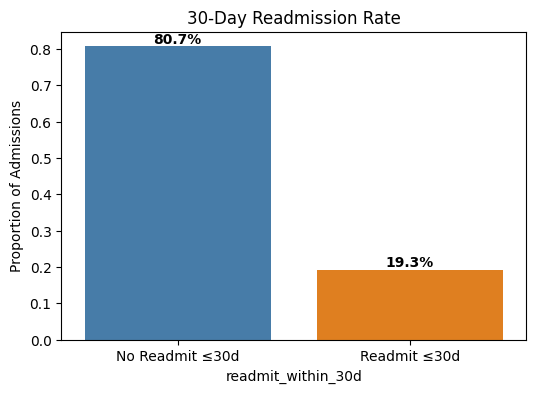

In [13]:
# Copy admissions table
admissions = hosp_data["admissions"].copy()

# --- Ensure datetime dtypes ---
for col in ["admittime", "dischtime"]:
    admissions[col] = pd.to_datetime(admissions[col], errors="coerce")

# Sort chronologically by patient
admissions = admissions.sort_values(["subject_id", "admittime"])

# Next admission timestamp per patient
admissions["next_admit"] = admissions.groupby("subject_id")["admittime"].shift(-1)

# Days between discharge and the next admission
delta_days = (admissions["next_admit"] - admissions["dischtime"]).dt.total_seconds() / 86400.0

# Flag readmission within 30 days
admissions["readmit_within_30d"] = delta_days.between(0, 30, inclusive="both").fillna(False)

# Compute proportions for annotation
counts = admissions["readmit_within_30d"].value_counts()
props = counts / counts.sum() * 100

# Plot bar chart
plt.figure(figsize=(6,4))
ax = sns.barplot(
    data=admissions,
    x="readmit_within_30d",
    y="readmit_within_30d",
    estimator=lambda x: len(x) / len(admissions),
    hue="readmit_within_30d",
    palette=["#377eb8", "#ff7f00"],
    legend=False
)

# Customize plot
ax.set_xticks([0,1])
ax.set_xticklabels(["No Readmit ≤30d","Readmit ≤30d"])
ax.set_ylabel("Proportion of Admissions")
ax.set_title("30-Day Readmission Rate")

# Add percentage labels above bars
for p, pct in zip(ax.patches, props):
    ax.annotate(f"{pct:.1f}%", 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.show()

**Age Distribution of ICU Patients**

**Purpose:**
- Characterizing the age distribution provides a baseline demographic profile of ICU patients. This supports the success criterion of achieving descriptive coverage for ≥90% of the sample.

**Code breakdown:**
- **Copy patients table**: Work on a copy of the `patients` table.  
- **Plot histogram with KDE**: Use seaborn’s `histplot` to show age distribution with a smooth density curve.  
- **Customize labels and title**: Add clear axis labels and descriptive title.

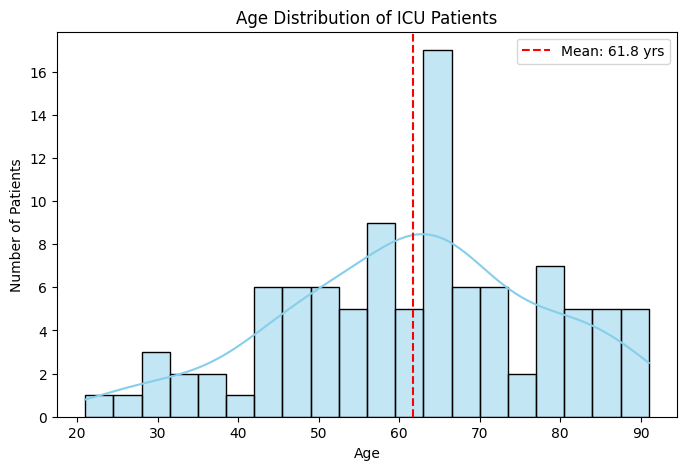

In [14]:
patients = hosp_data["patients"].copy()

# Compute mean age
mean_age = patients["anchor_age"].mean()

# Plot histogram with KDE
plt.figure(figsize=(8,5))
sns.histplot(patients["anchor_age"], bins=20, kde=True, color="skyblue")

# Add mean reference line
plt.axvline(mean_age, color="red", linestyle="--", label=f"Mean: {mean_age:.1f} yrs")

# Customize plot
plt.title("Age Distribution of ICU Patients")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.legend()
plt.show()


**Top Comorbidities (ICD Codes)**

**Purpose:**
- Comorbidity patterns help administrators understand the clinical burden and common drivers of ICU utilization. Visualizing the most frequent diagnoses supports the project’s aim to profile comorbidities across ≥90% of the sample.

**Code breakdown:**
- **Copy diagnoses table**: Extract the `diagnoses_icd` table for comorbidity analysis.  
- **Count diagnosis codes**: Identify the top 10 most frequent ICD codes.  
- **Plot bar chart**: Show counts of admissions per ICD code using seaborn’s `barplot`.  
- **Customize labels**: Add title, axis labels, and ensure readability.  

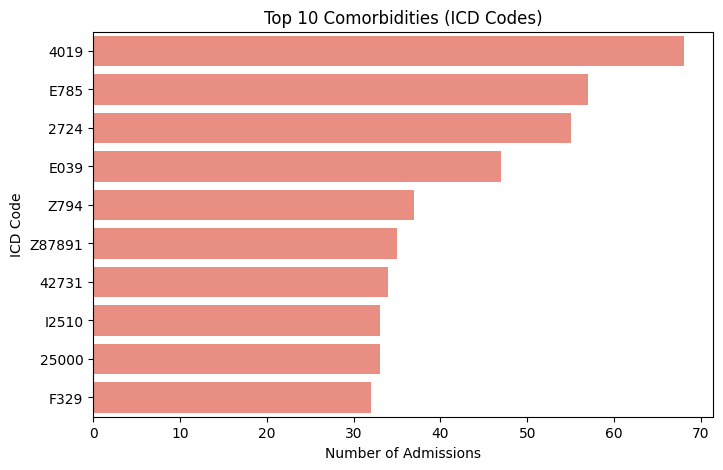

In [15]:
diagnoses = hosp_data["diagnoses_icd"].copy()

top_dx = diagnoses["icd_code"].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_dx.values, y=top_dx.index, color="salmon")
plt.title("Top 10 Comorbidities (ICD Codes)")
plt.xlabel("Number of Admissions")
plt.ylabel("ICD Code")
plt.show()

**ICU Length of Stay (LOS) by Admission Unit**

**Purpose:**
- Comparing length of stay (LOS) across different care units highlights where prolonged ICU stays are most common. This supports the goal of identifying predictors of resource-intensive admissions.

**Code breakdown:**
- **Copy ICU stays table**: Work on a copy of the `icustays` table.  
- **Compute LOS in days**: Convert `intime` and `outtime` to datetimes and calculate stay length.  
- **Merge with unit info**: Use the `first_careunit` variable for comparison.  
- **Plot boxplots**: Display LOS distributions by unit with seaborn’s `boxplot`.  
- **Customize labels**: Add axis labels, title, and rotate x-ticks for clarity.   

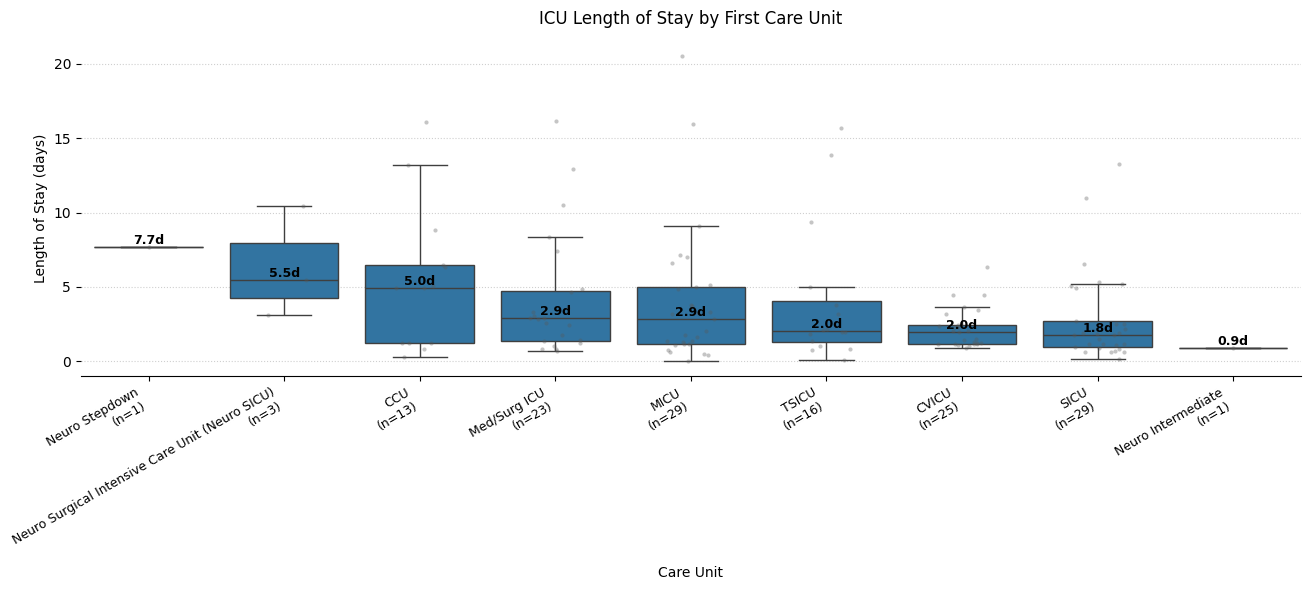

In [16]:
# --- Compute LOS and tidy unit labels ---
icustays = icu_data["icustays"].copy()
icustays["los_days"] = (
    pd.to_datetime(icustays["outtime"]) - pd.to_datetime(icustays["intime"])
).dt.total_seconds() / 86400.0

# Shorten long unit names (falls back to original if not in dict)
unit_map = {
    "Medical Intensive Care Unit (MICU)": "MICU",
    "Surgical Intensive Care Unit (SICU)": "SICU",
    "Medical/Surgical Intensive Care Unit (MICU/SICU)": "Med/Surg ICU",
    "Coronary Care Unit (CCU)": "CCU",
    "Cardiac Vascular Intensive Care Unit (CVICU)": "CVICU",
    "Trauma SICU (TSICU)": "TSICU",
    "Neuro Stepdown": "Neuro Stepdown",
    "Neuro Surgical Intensive Care Unit": "Neuro SICU",
    "Cardiac Surgery Recovery Unit (CSRU)": "CSRU",
    "Neuro Intermediate": "Neuro Intermediate",
}
icustays["unit_short"] = icustays["first_careunit"].map(unit_map).fillna(icustays["first_careunit"])

# --- Order categories by median LOS (change to 'counts.sort_values()' to sort by n) ---
medians = icustays.groupby("unit_short")["los_days"].median().sort_values(ascending=False)
order = medians.index.tolist()

# Sample sizes (n) for x-axis labels
counts = icustays["unit_short"].value_counts()
xticklabels = [f"{u}\n(n={counts.get(u,0)})" for u in order]

# --- Plot ---
n_units = len(order)
plt.figure(figsize=(max(10, 1.5 * n_units), 6))  # dynamic width scales with #units

ax = sns.boxplot(
    data=icustays, x="unit_short", y="los_days",
    order=order, showfliers=False
)

# Jittered points for distribution context
sns.stripplot(
    data=icustays, x="unit_short", y="los_days",
    order=order, color="0.35", alpha=0.35, size=3, jitter=0.2
)

# Annotate median LOS on each category
for i, u in enumerate(order):
    m = medians.loc[u]
    ax.text(i, m, f"{m:.1f}d", ha="center", va="bottom", fontsize=9, fontweight="bold")

# Styling / layout
ax.set_title("ICU Length of Stay by First Care Unit", pad=12)
ax.set_xlabel("Care Unit")
ax.set_ylabel("Length of Stay (days)")
ax.set_xticks(range(len(order)))
ax.set_xticklabels(xticklabels, rotation=30, ha="right", fontsize=9)
ax.yaxis.grid(True, linestyle=":", alpha=0.6)
sns.despine(left=True, bottom=False)
plt.tight_layout()
plt.show()

**Segmentation Potential: LOS vs Age**

**Purpose:**
- Plotting LOS against patient age offers an early view of how patients might segment into distinct groups, which will guide later clustering analysis (targeting 3–5 clinically meaningful clusters).

Code breakdown:
- **Merge ICU and patient tables**: Combine `icustays` with `patients` to link age and LOS.  
- **Compute LOS in days**: Ensure consistent calculation of stay length.  
- **Scatterplot**: Plot age on the x-axis and LOS on the y-axis with seaborn’s `scatterplot`.  
- **Adjust style**: Add transparency to points and customize axis labels and title.   

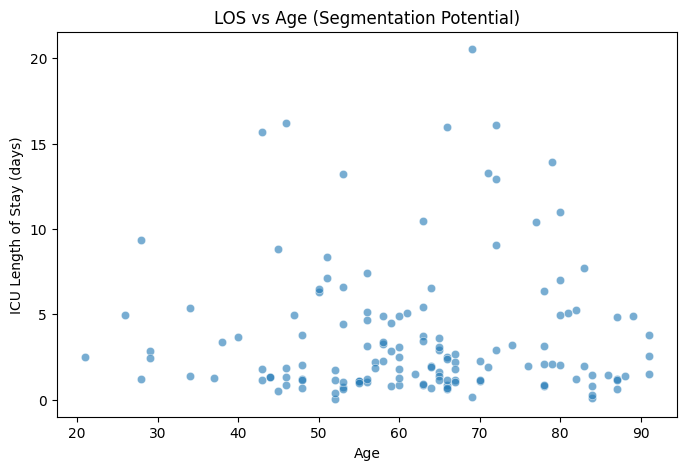

In [17]:
merged = icustays.merge(patients, on="subject_id")

plt.figure(figsize=(8,5))
sns.scatterplot(data=merged, x="anchor_age", y="los_days", alpha=0.6)
plt.title("LOS vs Age (Segmentation Potential)")
plt.xlabel("Age")
plt.ylabel("ICU Length of Stay (days)")
plt.show()

**Gender Distribution of Patients**

**Purpose:**
- Establish baseline cohort composition to support operational benchmarking and model fairness checks (e.g., ensure no systematic imbalance that could bias predictions or outcomes).

**Code breakdown:**
- **Select and clean**: Use a null-free `gender` Series for correct denominators.
- **Plot counts**: Visualize frequencies with a bar chart for quick comparison across categories.
- **Annotate bars**: Add % labels to make the figure self-contained and presentation-ready.
- **Tidy layout**: Keep axes simple and ensure labels don’t overlap.

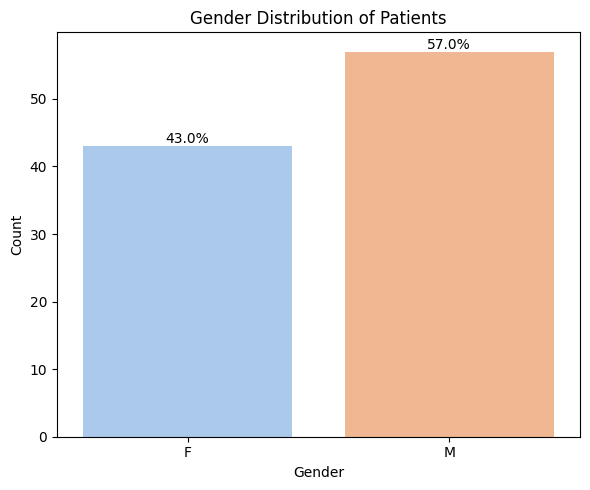

In [18]:
g = patients["gender"].dropna()
total = len(g)

plt.figure(figsize=(6,5))
ax = sns.countplot(x=g, hue=g, palette="pastel", legend=False)
ax.set_title("Gender Distribution of Patients")
ax.set_xlabel("Gender")
ax.set_ylabel("Count")

for p in ax.patches:
    h = p.get_height()
    pct = (h / total * 100) if total else 0
    ax.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width()/2, h),
                ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

**Admission Types**

**Purpose:**
- Characterize intake pathways to contextualize case-mix, staffing needs, and downstream comparisons of outcomes (e.g., LOS/readmission) across admission routes.

**Code breakdown:**
- **Select and order**: Build category order from `value_counts()` to sort bars by frequency.
- **Plot counts**: Bar chart highlights dominance (e.g., Emergency) versus less common types.
- **Annotate bars**: Percentages clarify relative contributions for administrators and clinicians.
- **Improve readability**: Rotate longer x-labels to prevent truncation.

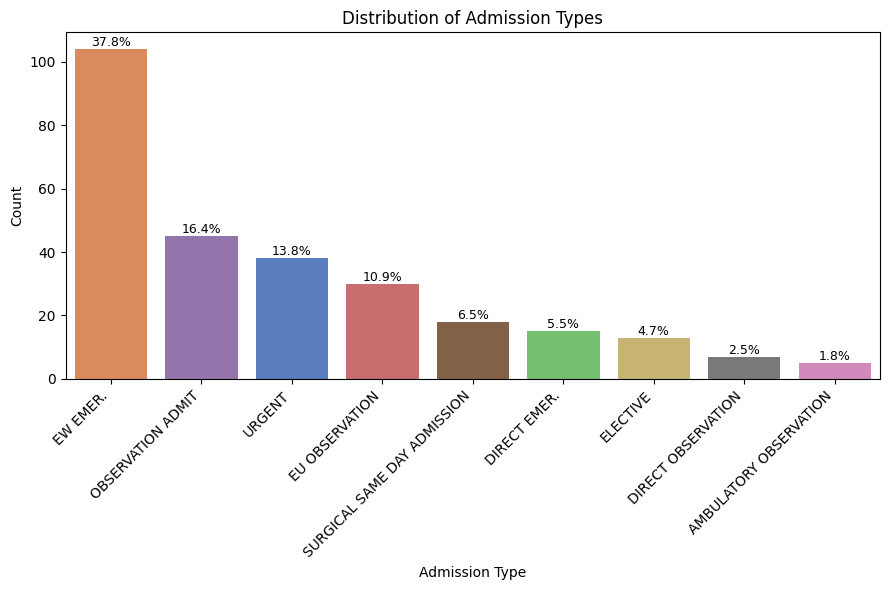

In [19]:
adm_type = admissions["admission_type"].dropna()
order = adm_type.value_counts().index
total = len(adm_type)

plt.figure(figsize=(9,6))
ax = sns.countplot(x=adm_type, hue=adm_type, order=order, palette="muted", legend=False)
ax.set_title("Distribution of Admission Types")
ax.set_xlabel("Admission Type")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")

for p in ax.patches:
    h = p.get_height()
    pct = (h / total * 100) if total else 0
    ax.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width()/2, h),
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

**Insurance Types**

**Purpose:**
- Summarize payer distribution to inform equity, utilization, and financial impact analyses; supports stratified reporting of outcomes and resource use.

**Code breakdown:**
- **Select and order**: Sort categories by observed frequency for a clean left-to-right descent.
- **Plot counts**: Show absolute volumes per payer to anchor operational planning.
- **Annotate bars**: Add % labels so the figure stands alone in the report.
- **Handle labels**: Rotate x-ticks for longer payer names.

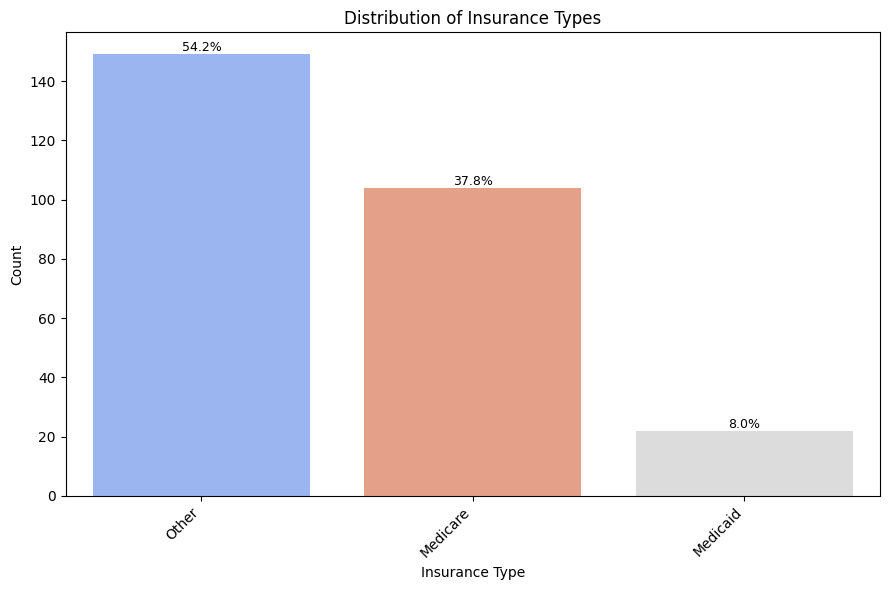

In [20]:
ins = admissions["insurance"].dropna()
order = ins.value_counts().index
total = len(ins)

plt.figure(figsize=(9,6))
ax = sns.countplot(x=ins, hue=ins, order=order, palette="coolwarm", legend=False)
ax.set_title("Distribution of Insurance Types")
ax.set_xlabel("Insurance Type")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")

for p in ax.patches:
    h = p.get_height()
    pct = (h / total * 100) if total else 0
    ax.annotate(f"{pct:.1f}%", (p.get_x() + p.get_width()/2, h),
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

**Demographics vs. Admissions: Age by Admission Type**

**Purpose:**
- Explore how age distributions vary across admission types to assess whether certain demographic groups are disproportionately represented in emergency admissions.
- Provides context for case-mix and operational planning.

**Code breakdown:**
- **Join data**: Merge `patients` with `admissions` to link age and admission type.
- **Clean data**: Drop missing values to ensure accurate results.
- **Plot distribution**: Use boxplots of age by admission type to compare medians and spreads.
- **Style**: Rotate labels for readability and apply consistent color palette.

C:\Users\shawn\AppData\Local\Temp\ipykernel_14712\1329295858.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=demo_adm, x="admission_type", y="anchor_age", palette="muted")


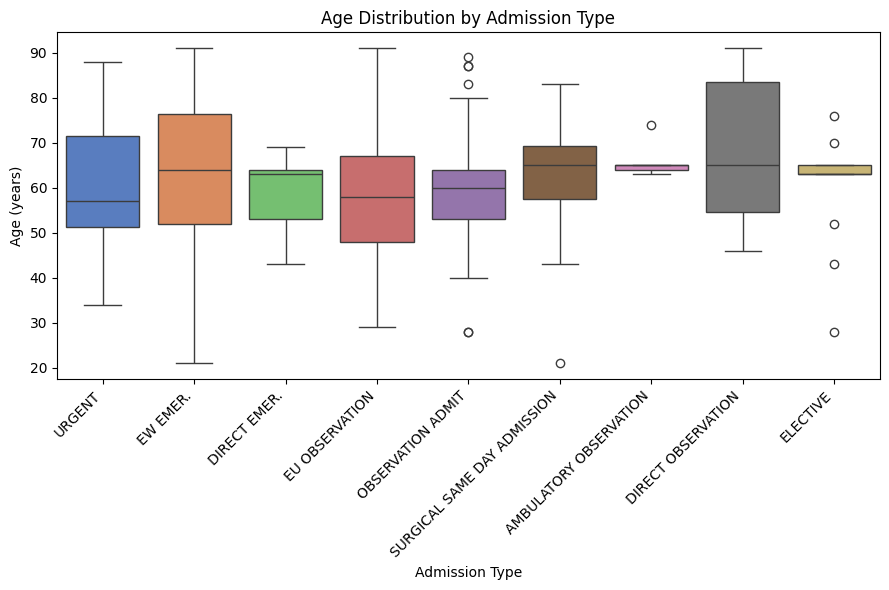

In [21]:
demo_adm = admissions.merge(patients[["subject_id","anchor_age"]], on="subject_id", how="left")

plt.figure(figsize=(9,6))
ax = sns.boxplot(data=demo_adm, x="admission_type", y="anchor_age", palette="muted")
ax.set_title("Age Distribution by Admission Type")
ax.set_xlabel("Admission Type")
ax.set_ylabel("Age (years)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Multiple ICU Stays per Admission**

**Purpose:**
- Identify the prevalence of patients with >1 ICU stay during the same hospital admission.
- Supports the argument that within-hospital readmissions must be carefully accounted for in analyses.

**Code breakdown:**
- **Aggregate**: Count the number of ICU stays per `hadm_id` in `icustays`.
- **Summarize**: Tabulate frequency of admissions with 1, 2, 3+ ICU stays.
- **Visualize**: Bar plot of ICU stay counts per admission.

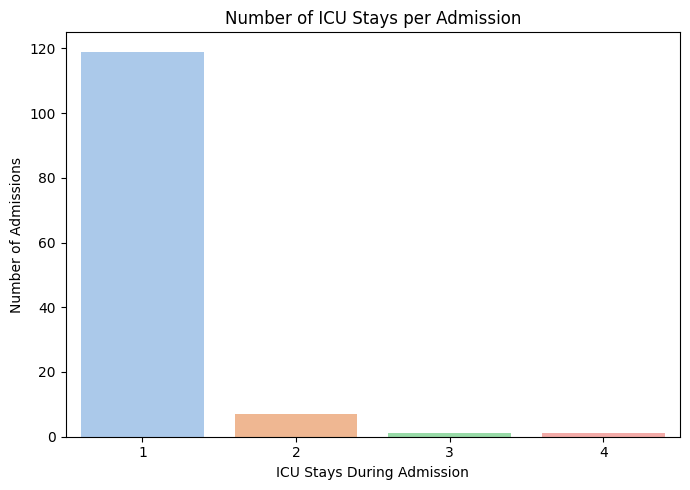

In [22]:
# Count ICU stays per hospital admission
icu_counts = icustays.groupby("hadm_id")["stay_id"].count().reset_index()
icu_counts = icu_counts.rename(columns={"stay_id": "icu_stay_count"})

# Summarize distribution
icu_dist = icu_counts["icu_stay_count"].value_counts().sort_index().reset_index()
icu_dist.columns = ["icu_stay_count", "num_admissions"]

plt.figure(figsize=(7,5))
ax = sns.barplot(data=icu_dist,
                 x="icu_stay_count",
                 y="num_admissions",
                 hue="icu_stay_count",
                 palette="pastel",
                 legend=False)
ax.set_title("Number of ICU Stays per Admission")
ax.set_xlabel("ICU Stays During Admission")
ax.set_ylabel("Number of Admissions")
plt.tight_layout()
plt.show()

**ICU Length of Stay Outliers**

**Purpose:**
- Highlight the presence of extreme ICU stays that defy typical expectations (e.g., > 100 days).
- Demonstrates the need to handle outliers carefully in modeling and reporting.

**Code breakdown:**
- **Extract**: ICU length of stay (`los`) from `icustays`.
- **Summarize**: Compute descriptive stats (median, IQR, max).
- **Visualize**: Boxplot of LOS (with log scale if needed) to emphasize extreme outliers.

count    140.000000
mean       3.679379
std        3.896354
min        0.023727
25%        1.170663
50%        2.155093
75%        4.907749
max       20.528681
Name: los, dtype: float64


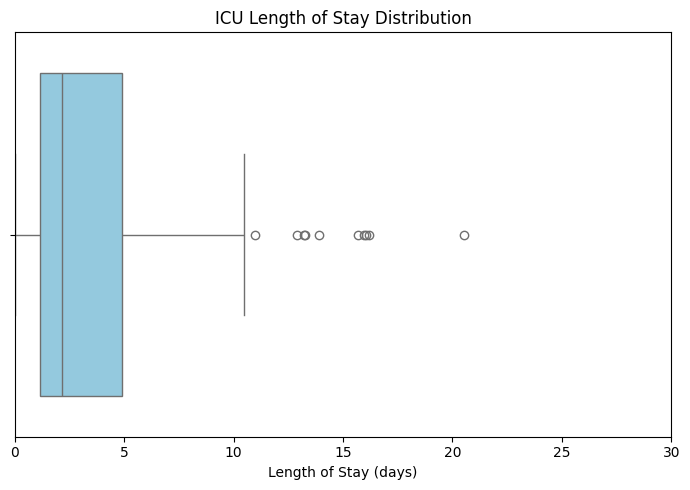

In [23]:
# Inspect LOS distribution
print(icustays["los"].describe())

plt.figure(figsize=(7,5))
ax = sns.boxplot(data=icustays,
                 x="los",
                 color="skyblue")
ax.set_title("ICU Length of Stay Distribution")
ax.set_xlabel("Length of Stay (days)")

# Optionally zoom in (clip extreme outliers for clarity)
plt.xlim(0, 30)  # show first 30 days, but extremes exist beyond this
plt.tight_layout()
plt.show()

**Completeness of Key Variables**

**Purpose:**
- Assess data quality by quantifying missingness across variables.
- Identify which fields are fully populated (e.g., IDs) versus those with partial missingness that may impact analyses.

**Code breakdown:**
- **Select variables**: Use representative columns from `patients`, `admissions`, and `icustays`.
- **Calculate missingness**: For each column, compute % of missing values.
- **Visualize**: Horizontal bar plot with % missing per variable, highlighting sparsity.
- **Style**: Order bars descending so the sparsest variables appear at the top.

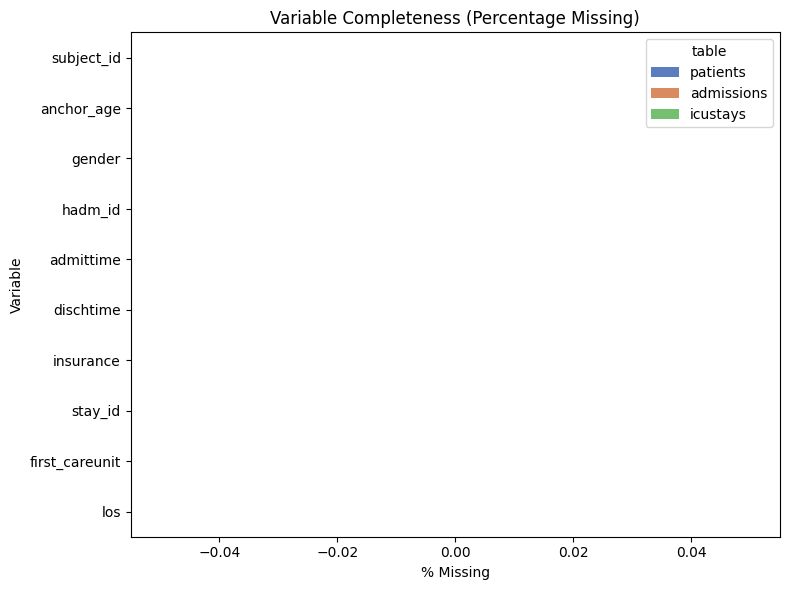

,table,column,pct_missing
0,patients,subject_id,0.0
1,patients,anchor_age,0.0
2,patients,gender,0.0
3,admissions,hadm_id,0.0
4,admissions,admittime,0.0
5,admissions,dischtime,0.0
6,admissions,insurance,0.0
7,icustays,stay_id,0.0
8,icustays,first_careunit,0.0
9,icustays,los,0.0


In [24]:
# Combine a few representative dataframes into one completeness check
cols_to_check = {
    "patients": ["subject_id", "anchor_age", "gender"],
    "admissions": ["hadm_id", "admittime", "dischtime", "insurance"],
    "icustays": ["stay_id", "first_careunit", "los"]
}

missing_summary = []

for df_name, cols in cols_to_check.items():
    df = globals()[df_name]
    for col in cols:
        pct_missing = df[col].isna().mean() * 100
        missing_summary.append({"table": df_name, "column": col, "pct_missing": pct_missing})

missing_df = pd.DataFrame(missing_summary)

# Sort descending by % missing
missing_df = missing_df.sort_values("pct_missing", ascending=False)

# Plot
plt.figure(figsize=(8,6))
ax = sns.barplot(
    data=missing_df,
    y="column",
    x="pct_missing",
    hue="table",
    dodge=False,
    palette="muted",
    legend=True
)
ax.set_title("Variable Completeness (Percentage Missing)")
ax.set_xlabel("% Missing")
ax.set_ylabel("Variable")
plt.tight_layout()
plt.show()

# Display table for reference
missing_df


**Accuracy Assessment**

**Purpose:**
- Validate that key identifiers are unique and not duplicated.
- Check that critical values (e.g., age, length of stay, admission/discharge times) fall within plausible ranges.
- Confirm logical ordering of time stamps to ensure data consistency.

**Code breakdown:**
- **Identifiers**: Test uniqueness of `subject_id`, `hadm_id`, and `stay_id` within their respective tables.
- **Ranges**: Confirm `anchor_age` is within de-identified limits (0–90+), and `los` values are non-negative.
- **Timestamps**: Verify that `dischtime` occurs after `admittime`.

In [25]:
# --- Identifier checks ---
id_checks = {
    "patients.subject_id unique": patients["subject_id"].is_unique,
    "admissions.hadm_id unique": admissions["hadm_id"].is_unique,
    "icustays.stay_id unique": icustays["stay_id"].is_unique,
}

print("Identifier uniqueness checks:")
for k, v in id_checks.items():
    print(f"{k}: {v}")

# --- Range checks ---
print("\nRange checks:")
print(f"Anchor age min/max: {patients['anchor_age'].min()} / {patients['anchor_age'].max()}")
print(f"ICU LOS min/max: {icustays['los'].min()} / {icustays['los'].max()}")

# --- Timestamp logic ---
invalid_times = admissions[admissions["dischtime"] < admissions["admittime"]]
print(f"\nAdmissions with discharge before admit: {len(invalid_times)}")

Identifier uniqueness checks:
patients.subject_id unique: True
admissions.hadm_id unique: True
icustays.stay_id unique: True

Range checks:
Anchor age min/max: 21 / 91
ICU LOS min/max: 0.0237268518518518 / 20.52868055555556

Admissions with discharge before admit: 0
